# **Medical Image Processing: Assignment \#01**



## **Default Setting**

In [1]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.0 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub

import copy
import cv2
import os

import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
%%bash
wget https://www.melbourneradiology.com.au/wp-content/uploads/2021/06/MRI-BRAIN-WITH-CONTRAST-0001.jpg ./

--2022-03-10 02:56:55--  https://www.melbourneradiology.com.au/wp-content/uploads/2021/06/MRI-BRAIN-WITH-CONTRAST-0001.jpg
Resolving www.melbourneradiology.com.au (www.melbourneradiology.com.au)... 34.87.239.38
Connecting to www.melbourneradiology.com.au (www.melbourneradiology.com.au)|34.87.239.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72367 (71K) [image/jpeg]
Saving to: ‘MRI-BRAIN-WITH-CONTRAST-0001.jpg’

     0K .......... .......... .......... .......... .......... 70%  205K 0s
    50K .......... ..........                                 100% 1.63M=0.3s

2022-03-10 02:56:57 (275 KB/s) - ‘MRI-BRAIN-WITH-CONTRAST-0001.jpg’ saved [72367/72367]

--2022-03-10 02:56:57--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-03-10 02:56:57--
Total wall clock time: 1.2s
Downloaded: 1 files, 71K in 0.3s (275 KB/s)


In [4]:
SAVED_IMAGE_PATH = "MRI-BRAIN-WITH-CONTRAST-0001.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [5]:
!nvidia-smi; free -h

Thu Mar 10 02:56:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Fourier Transform**

In [6]:
## Total results.
results = {}

## Normalize function in range 0 to 1.
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

In [7]:
## Load and cast image.
image = cv2.imread(SAVED_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
results["1"] = image

In [8]:
## Type casting.
image = image.astype(np.float32)

## Perform FFT and FFT shift.
mfft = np.fft.fft2(image)
mfftshift = np.fft.fftshift(mfft)

results["4"] = norm(np.abs(mfftshift)) ** .1

In [9]:
## Crop high frequency components from center.
hc = mfftshift.shape[0] // 2 ## height center
wc = mfftshift.shape[1] // 2 ## width center
size = 50

mfftshiftcrop = mfftshift[hc-size:hc+size, wc-size:wc+size]
results["6"] = norm(np.abs(mfftshiftcrop)) ** .1

In [10]:
## Add zero padding components.
mfftshiftcrop_zeropadded = np.zeros_like(mfftshift)

mfftshiftcrop_zeropadded[hc-size:hc+size, wc-size:wc+size] = mfftshiftcrop
results["5"] = norm(np.abs(mfftshiftcrop_zeropadded)) ** .1

In [11]:
## Reconsult from mfftshiftcrop
recon = np.fft.ifft2(np.fft.fftshift(mfftshiftcrop))
results["3"] = np.abs(recon)

In [12]:
## Reconsult from mfftshiftcrop.
recon_zeropadded = np.fft.ifft2(np.fft.fftshift(mfftshiftcrop_zeropadded))
results["2"] = np.abs(recon_zeropadded)

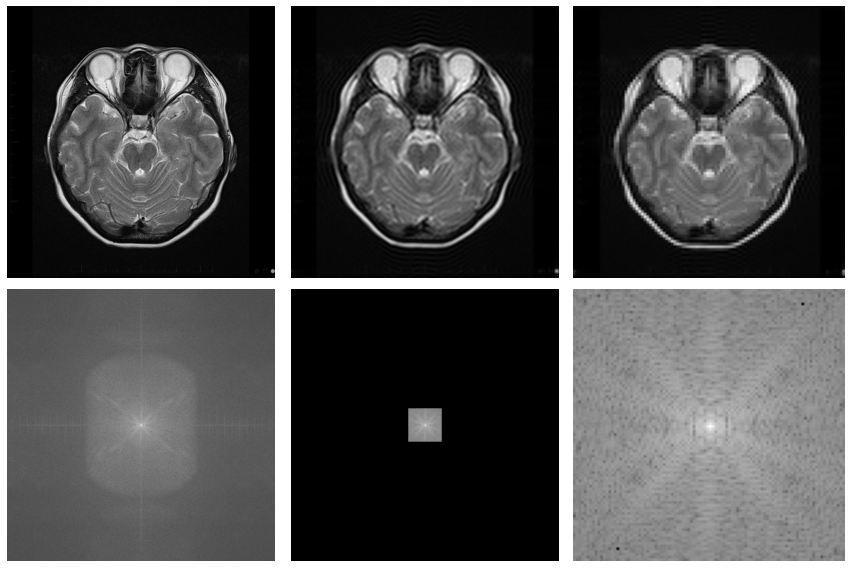

In [13]:
## Plot it.
fig = plt.figure(figsize=(12, 8), facecolor="white")

for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(results[str(i+1)], cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

## **Image High Resolution**

In [14]:
## Load backbone model.
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [47]:
## Pick two images for compare; original and damaged image.
ori_image = tf.convert_to_tensor(results["1"].astype(np.float32))

dmg_image = norm(results["2"]).astype(np.float32) * 255.
dmg_image = tf.convert_to_tensor(dmg_image)

## Print the information.
print(f"[Original Image] shape: {ori_image.shape}, dtype: {ori_image.dtype}")
print(f"[Damaged  Image] shape: {dmg_image.shape}, dtype: {dmg_image.dtype}")

[Original Image] shape: (814, 800), dtype: <dtype: 'float32'>
[Damaged  Image] shape: (814, 800), dtype: <dtype: 'float32'>


In [48]:
## Damaged PSNR
dmg_psnr = tf.image.psnr(
    dmg_image[..., tf.newaxis],
    ori_image[..., tf.newaxis],
    max_val=255,
)
print(f"Damaged PSNR: {dmg_psnr:.2f}")

Damaged PSNR: 26.75


In [55]:
%%time
rcn_image = tf.image.grayscale_to_rgb(dmg_image[tf.newaxis, ..., tf.newaxis])
rcn_image = model(rcn_image)

CPU times: user 720 ms, sys: 843 ms, total: 1.56 s
Wall time: 1.65 s


In [56]:
## Reduce dimension; batch-dim and channel-dim.
rcn_image = tf.image.rgb_to_grayscale(rcn_image)[0, ...]

print(f"[Reconstructed Image] shape: {rcn_image.shape}, dtype: {rcn_image.dtype}")

[Reconstructed Image] shape: (3256, 3200, 1), dtype: <dtype: 'float32'>


In [57]:
## Downsampling using bilinear method.
rcn_image = tf.image.resize(rcn_image, np.array(rcn_image.shape[:-1]) // 4)

print(f"[Reconstructed Image] shape: {rcn_image.shape}, dtype: {rcn_image.dtype}")

[Reconstructed Image] shape: (814, 800, 1), dtype: <dtype: 'float32'>


In [58]:
## Reconstructed PSNR
rcn_psnr = tf.image.psnr(
    rcn_image,
    ori_image[..., tf.newaxis],
    max_val=255,
)
print(f"Damaged PSNR: {rcn_psnr:.2f}")

Damaged PSNR: 26.76


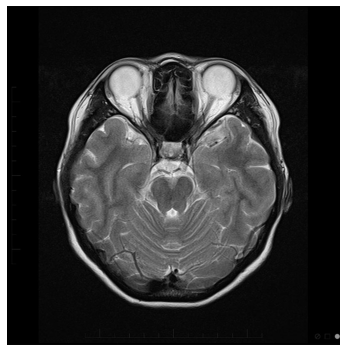

In [62]:
plt.figure(figsize=(5, 5), facecolor="white")

plt.imshow(ori_image, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.savefig("ori_image.png", dpi=300)
plt.show()

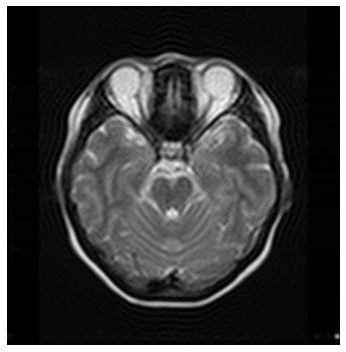

In [59]:
plt.figure(figsize=(5, 5), facecolor="white")

plt.imshow(dmg_image, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.savefig("dmg_image.png", dpi=300)
plt.show()

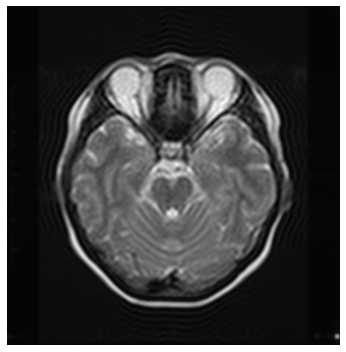

In [61]:
plt.figure(figsize=(5, 5), facecolor="white")

plt.imshow(rcn_image[..., 0], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.savefig("rcn_image.png", dpi=300)
plt.show()